<a href="https://colab.research.google.com/github/cihankaradogan/StyleGan2-Music-Reactive/blob/main/StyleGan2_MusicReactive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**My reference notebook**
**https://github.com/dvschultz/ai/blob/master/StyleGAN2_AudioReactive.ipynb**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

%cd /content/drive/My Drive/
!git clone https://github.com/NVlabs/stylegan2.git
%cd /content/drive/My Drive/stylegan2
!mkdir data

!nvcc test_nvcc.cu -o test_nvcc -run

!nvidia-smi -L

/content
/content/drive/My Drive/stylegan2
CPU says hello.
GPU says hello.
Tensorflow version: 1.15.2
GPU 0: Tesla P4 (UUID: GPU-37738adf-fa5e-68c1-1de0-218ff4a5f499)
GPU Identified at: /device:GPU:0


## Config

In [ ]:
import os
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import wavfile
import matplotlib.pyplot as plt
import moviepy.editor
import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks
import argparse
import PIL.Image
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio
import pretrained_networks

#Change this according to your network.
#I use pretrained "https://github.com/pbaylies/stylegan2" model. If you want, 
#you can train your own model but it takes a lot of times.
network_pkl = '/content/drive/My Drive/stylegan2/ağ.pkl'

print('Loading networks from "%s"...' % network_pkl)

_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 4
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
w_avg = Gs.get_var('dlatent_avg')

def get_ws(n, frames, seed):
    filename = f'data/ws_{n}_{frames}_{seed}.npy'
    if not os.path.exists(filename):
        src_ws = np.random.RandomState(seed).randn(n, 512)
        ws = np.empty((frames, 512))
        for i in range(512):
            x = np.linspace(0, 3*frames, 3*len(src_ws), endpoint=False)
            y = np.tile(src_ws[:, i], 3)
            x_ = np.linspace(0, 3*frames, 3*frames, endpoint=False)
            y_ = interp1d(x, y, kind='quadratic', fill_value='extrapolate')(x_)
            ws[:, i] = y_[frames:2*frames]
        np.save(filename, ws)
    else:
        ws = np.load(filename)
    return ws

def mix_styles(wa, wb, ivs):
    w = np.copy(wa)
    for i, v in ivs:
        w[i] = wa[i] * (1 - v) + wb[i] * v
    return w

def normalize_vector(v):
    return v * np.std(w_avg) / np.std(v) + np.mean(w_avg) - np.mean(v)

#You can change psi's value.
def render_frame(t):
    global base_index
    frame = np.clip(np.int(np.round(t * fps)), 0, frames - 1)
    base_index += base_speed * audio['accompaniment'][frame]**2
    base_w = base_ws[int(round(base_index)) % len(base_ws)]
    base_w = np.tile(base_w, (18, 1))
    psi = 0.8 + audio['drums'][frame] / 4
    base_w = w_avg + (base_w - w_avg) * psi
    mix_w = np.tile(mix_ws[frame], (18, 1))
    mix_w = w_avg + (mix_w - w_avg) * 0.75
    ranges = [range(0, 4), range(4, 8), range(8, 18)]
    values = [audio[track][frame] for track in ['fx', 'fx', 'fx']]
    w = mix_styles(base_w, mix_w, zip(ranges, values))
    w += mouth_open * audio['vocals'][frame] * 1.5
    image = Gs.components.synthesis.run(np.stack([w]), **Gs_syn_kwargs)[0]
    image = PIL.Image.fromarray(image).resize((size, size), PIL.Image.LANCZOS)
    return np.array(image)

Loading networks from "/content/drive/My Drive/stylegan2/ağ.pkl"...


##Audio Splitting
1. Use https://www.splitter.ai/ to split mp3's instrument into 5, 
so select 5 Stem Model.
2. Rename your mp3s 
- other.mp3 > accompaniment.mp3
- original_track.mp3 > all.mp3
- bass.mp3 or piano.mp3 > fx.mp3 
<br>(sometimes the bass mp3 is empty)
3. Upload the 5 mp3s to "/content/drive/My Drive/stylegan2/data/"
- accompaniment
- vocals
- drums
- fx
- all

track_name = all
track_name = fx
track_name = accompaniment
track_name = drums
[MoviePy] Writing audio in data/vocals.wav


100%|██████████| 1325/1325 [00:00<00:00, 1822.92it/s]

[MoviePy] Done.


track_name = vocals


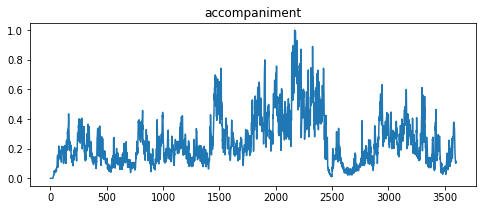

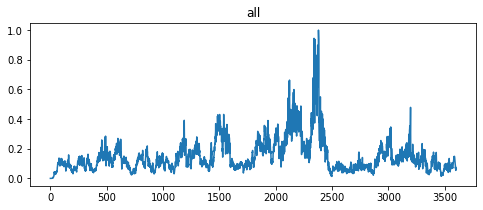

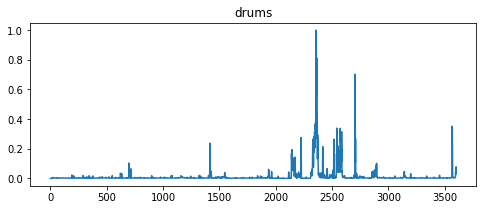

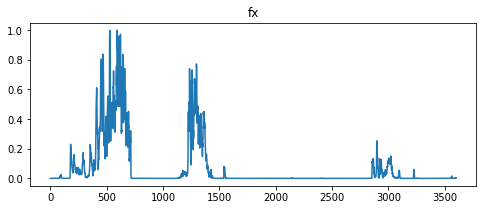

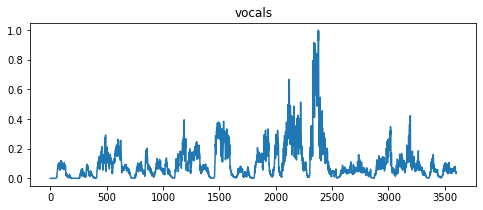

In [ ]:
audio = {}
fps = 60

for mp3_filename in [f for f in os.listdir('data') if f.endswith('.mp3')]:
    mp3_filename = f'data/{mp3_filename}'
    wav_filename = mp3_filename[:-4] + '.wav'
    if not os.path.exists(wav_filename):
        audio_clip = moviepy.editor.AudioFileClip(mp3_filename)
        audio_clip.write_audiofile(wav_filename, fps=44100, nbytes=2, codec='pcm_s16le')
    track_name = os.path.basename(wav_filename)[:-4]
    print("track_name = " + str(track_name))
    rate, signal = wavfile.read(wav_filename)
    signal = np.mean(signal, axis=1)
    signal = np.abs(signal)
    abitofrandomforseed = np.random.randint(50, size=1) #You can change 50 to generate different seeds.
    seed = signal.shape[0] + abitofrandomforseed[0]
    duration = signal.shape[0] / rate
    frames = int(np.ceil(duration * fps))
    samples_per_frame = signal.shape[0] / frames
    audio[track_name] = np.zeros(frames, dtype=signal.dtype)
    for frame in range(frames):
        start = int(round(frame * samples_per_frame))
        stop = int(round((frame + 1) * samples_per_frame))
        audio[track_name][frame] = np.mean(signal[start:stop], axis=0)
    audio[track_name] /= max(audio[track_name])

for track in sorted(audio.keys()):
    plt.figure(figsize=(8, 3))
    plt.title(track)
    plt.plot(audio[track])
    plt.savefig(f'data/{track}.png')
print(audio)

##Make Video

**If this part returns an error code, run the above code until the error is fixed.**

In [ ]:
size = 1080
seconds = int(np.ceil(duration))
resolution = 10
base_frames = resolution * frames
base_ws = get_ws(seconds, base_frames, seed)
base_speed = base_frames / sum(audio['vocals']**2)
base_index = 0
mix_ws = get_ws(seconds, frames, seed + 1)
#You should download a vector from "https://rolux.org/media/stylegan2/vectors/" 
#and upload to "/content/drive/My Drive/stylegan2/data/".
#mouth_ratio.npy works well.
mouth_open = normalize_vector(-np.load('/content/drive/My Drive/stylegan2/data/eye_ratio.npy'))
# change the output filename according to npy
mp4_filename = 'data/filename-mouth_ratio.mp4'
video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
audio_clip = moviepy.editor.AudioFileClip('data/all.wav')
video_clip = video_clip.set_audio(audio_clip)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='8M')


[MoviePy] >>>> Building video data/filename-mouth_ratio.mp4
[MoviePy] Writing audio in filename-mouth_ratioTEMP_MPY_wvf_snd.mp4


100%|██████████| 1324/1324 [00:02<00:00, 593.62it/s]

[MoviePy] Done.
[MoviePy] Writing video data/filename-mouth_ratio.mp4



100%|██████████| 3604/3604 [10:07<00:00,  5.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: data/filename-mouth_ratio.mp4 

